In [1]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split


csv_file_path = '/Users/shubhibhadauriya/Desktop/Diss Project/001 2/001_0.csv'
image_base_path = '/Users/shubhibhadauriya/Desktop/Diss Project/0'  # Point to the directory containing images


data = pd.read_csv(csv_file_path)


print(data.head())
print("Columns in DataFrame:", data.columns)


data = data.dropna()


image_width, image_height = 640, 480
data['lx'] = data['lx'] / image_width
data['ly'] = data['ly'] / image_height
data['rx'] = data['rx'] / image_width
data['ry'] = data['ry'] / image_height


features = ['lx', 'ly', 'rx', 'ry']


def find_image_file(csv_filename, image_dir):
   
    parts = csv_filename.split('/')
    timestamp_id = parts[-1].split('-')[0]  

    
    corrected_timestamp_id = timestamp_id.replace(':', '/')
    
    
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if corrected_timestamp_id in file:
                return os.path.join(root, file)
    return None  


def load_images(filenames, base_path):
    images = []
    for filename in filenames:
        img_path = find_image_file(filename, base_path)
        if img_path and os.path.exists(img_path):
            img = load_img(img_path, target_size=(image_height, image_width), color_mode='rgb')
            img_array = img_to_array(img)
            images.append(img_array)
        else:
            print(f"File not found for CSV entry: {filename}")
            images.append(np.zeros((image_height, image_width, 3)))  # Insert a blank image if not found
    return np.array(images)


filenames = data['filename'].values
X_images = load_images(filenames, image_base_path)


y = data[features].values


if X_images.shape[0] != y.shape[0]:
    raise ValueError(f"Inconsistent number of images ({X_images.shape[0]}) and labels ({y.shape[0]}).")


X_train, X_temp, y_train, y_temp = train_test_split(X_images, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

2024-08-13 23:56:16.869655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


   Unnamed: 0                                    filename  LE_left  LE_top  \
0           0  001/0/2022-09-26 08:07:22.792702-37704.jpg      131     410   
1           1  001/0/2022-09-26 08:07:23.101953-37752.jpg      163     479   
2           2  001/0/2022-09-26 08:07:22.818864-37708.jpg      130     410   
3           3  001/0/2022-09-26 08:07:23.225207-37772.jpg      183     523   
4           4  001/0/2022-09-26 08:07:23.126469-37756.jpg      167     481   

   LE_right  LE_bottom  RE_left  RE_top  RE_right  RE_bottom   lx   ly   rx  \
0       375        525      633     429       856        545  252  470  766   
1       379        564      621     479       821        584  260  531  740   
2       373        525      632     431       854        547  255  471  763   
3       380        593      624     526       807        610  261  572  723   
4       379        566      622     480       822        583  262  540  733   

    ry  relative_lx  relative_ly  relative_rx  relative_

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


initial_learning_rate = 0.001
epochs = 100  
batch_size = 32  

def build_dense_model(learning_rate=0.001):
    model = Sequential([
        Dense(128, input_shape=(X_train_flat.shape[1],), activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4, activation='linear')  # Assuming you have 4 output features: lx, ly, rx, ry
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

initial_learning_rate = 0.001

# Build the dense model with the correct input shape
dense_model = build_dense_model(learning_rate=initial_learning_rate)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


dense_history = dense_model.fit(X_train_flat, y_train, 
                                validation_data=(X_val_flat, y_val), 
                                epochs=epochs, 
                                batch_size=batch_size,
                                callbacks=[early_stopping, reduce_lr])

# Evaluate on test data
#dense_test_loss, dense_test_mae = dense_model.evaluate(X_test_flat, y_test)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - loss: 9236910.0000 - mae: 1758.3120 - val_loss: 12531227.0000 - val_mae: 3077.9438 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 7547019.0000 - mae: 2211.2185 - val_loss: 3142888.0000 - val_mae: 1511.5804 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 2816159.2500 - mae: 1415.3740 - val_loss: 1097926.2500 - val_mae: 908.9563 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 1646098.7500 - mae: 1124.1099 - val_loss: 728720.3125 - val_mae: 696.0622 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 979959.0625 - mae: 819.9902 - val_loss: 564500.6875 - val_mae: 478.1631 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 660607.0625 - mae: 602.7795 - val_loss: 366345.7188 - val_mae: 544.2468 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 442344.8750 -

Matplotlib is building the font cache; this may take a moment.


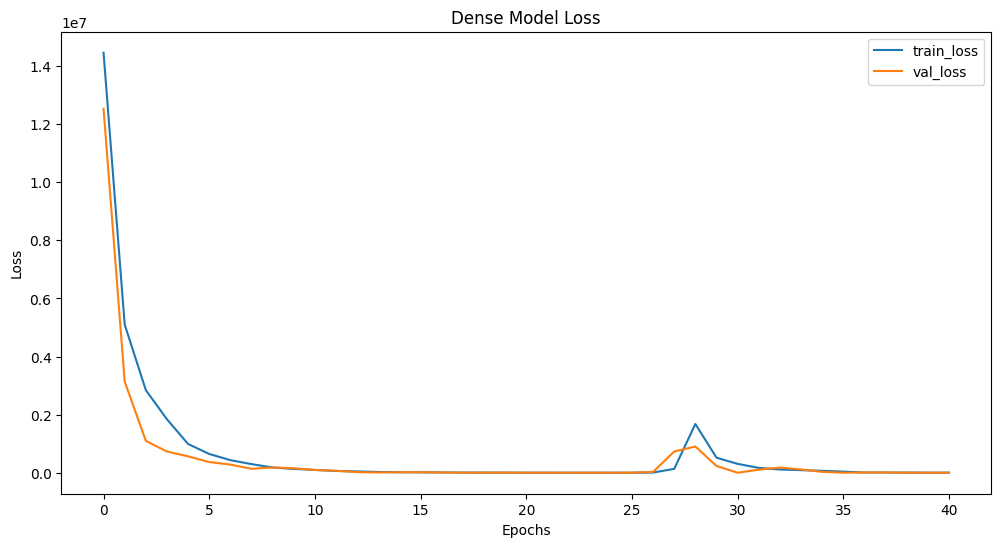

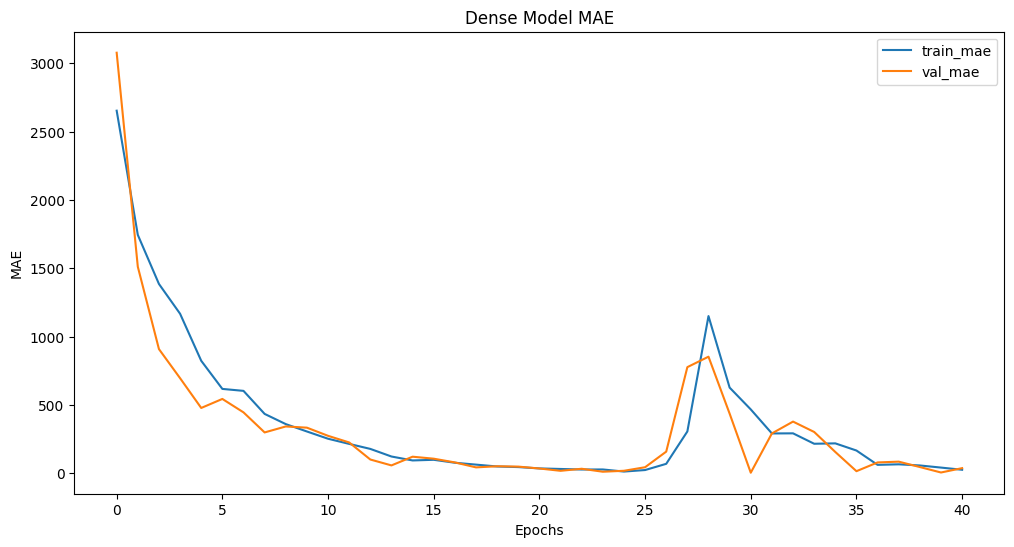

In [10]:

import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='train_mae')
    plt.plot(history.history['val_mae'], label='val_mae')
    plt.title(f'{model_name} MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

# Plot histories
#plot_history(cnn_history, 'CNN Model')
plot_history(dense_history, 'Dense Model')
